In [45]:

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np
from qiskit.primitives import Sampler
import pandas as pd
import networkx as nx
#import pygraphviz
import matplotlib.pyplot as plt

size = 5

qreg_q = QuantumRegister(size, 'q')
creg_c = ClassicalRegister(size, 'c')
circuit = QuantumCircuit(qreg_q)

circuit.h(qreg_q[0])
circuit.h(qreg_q[1])
circuit.ch(qreg_q[1], qreg_q[0])
circuit.rz(np.pi/2, qreg_q[1])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.ch(qreg_q[0], qreg_q[1])
circuit.h(qreg_q[0])
circuit.h(qreg_q[1])


tests = range(1,int(2**size))

circuit_list = []

for test in tests:
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list += [circuit_sampler]
    
display(circuit_list[0].decompose().draw(fold=100))

    

┌───────────────────────┐┌───┐┌───┐                     ┌───┐ ░ ┌─┐            
   q_0: ─|0>─┤0                      ├┤ H ├┤ H ├─────────────■────■──┤ H ├─░─┤M├────────────
             │                       │├───┤└─┬─┘┌─────────┐┌─┴─┐┌─┴─┐├───┤ ░ └╥┘┌─┐         
   q_1: ─|0>─┤1                      ├┤ H ├──■──┤ Rz(π/2) ├┤ X ├┤ H ├┤ H ├─░──╫─┤M├─────────
             │                       │└───┘     └─────────┘└───┘└───┘└───┘ ░  ║ └╥┘┌─┐      
   q_2: ─|0>─┤2 State Preparation(1) ├─────────────────────────────────────░──╫──╫─┤M├──────
             │                       │                                     ░  ║  ║ └╥┘┌─┐   
   q_3: ─|0>─┤3                      ├─────────────────────────────────────░──╫──╫──╫─┤M├───
             │                       │                                     ░  ║  ║  ║ └╥┘┌─┐
   q_4: ─|0>─┤4                      ├─────────────────────────────────────░──╫──╫──╫──╫─┤M├
             └───────────────────────┘                                     ░  ║  ║  ║  ║ └╥┘
meas: 5/══════════════════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                              0  1  2  3  4

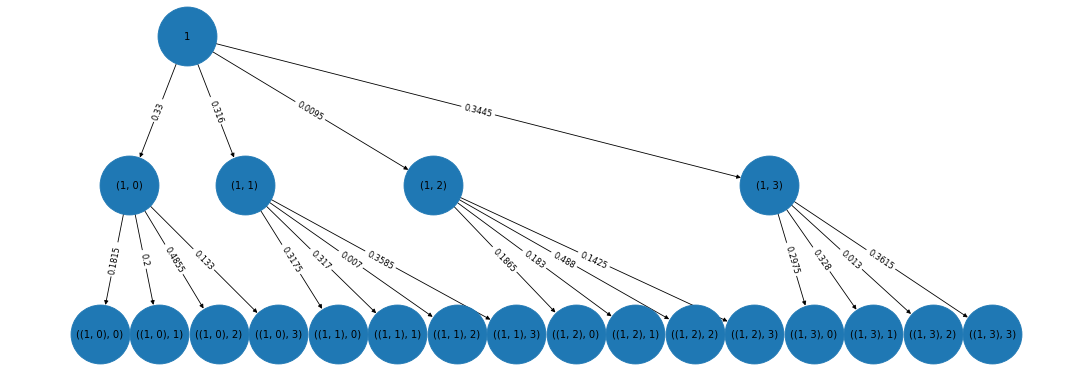

In [46]:
    
sampler = Sampler()
job = sampler.run(circuit_list,shots = 2000)
result = job.result()
df = pd.DataFrame(list(enumerate(result.quasi_dists,1)))
df.set_index(0, inplace=True)

df = df[1].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 1, 1: "one"})
df[1] = df[1].astype(int)
df.set_index(1, append=True, inplace=True)

tree = df.loc[[1]]
tree["weight"] = tree["one"]
tree = tree["weight"].to_frame()
tree["leaf"] = tree.index.get_level_values(1)
tree.index = tree.index.to_flat_index()
dft = tree[["weight","leaf"]]


for i in range(2,3):
    dft = dft[["weight","leaf"]]
    tree_list = []

    for test in list(dft.leaf.to_list()):
        circuit_sampler = QuantumCircuit(qreg_q)
        circuit_sampler.initialize(test)
        circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
        circuit_sampler.measure_all()
        tree_list += [circuit_sampler]

    job_tree = sampler.run(tree_list,shots = 2000).result()

    dft["weight"] = pd.DataFrame(list(enumerate(job_tree.quasi_dists,1)))[1].values

    dft = dft["weight"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: i, 1: "weight"})

    dft[i] = dft[i].astype(int)
    dft.set_index(i, append=True, inplace=True)
    dft["leaf"] = dft.index.get_level_values(1)
    dft.index = dft.index.to_flat_index()
    tree = pd.concat([tree,dft])
    
tree["leaf"] = tree.index.values

tree["parent"] = pd.Series(list(zip(*tree.leaf))[0]).values


tree_graph = nx.from_pandas_edgelist(tree, source='parent', target='leaf',edge_attr=["weight"],  create_using=nx.DiGraph)


fig = plt.figure(1, figsize=(18, 6), dpi=60)
tree_layout_graph = nx.nx_agraph.graphviz_layout(tree_graph, prog="dot")

labels = {e: tree_graph.get_edge_data(e[0], e[1])["weight"] for e in tree_graph.edges()}
nx.draw(tree_graph,tree_layout_graph, with_labels = True, node_size=5000)
nx.draw_networkx_edge_labels(tree_graph, pos=tree_layout_graph, edge_labels=labels)
plt.show()


In [47]:


circuit_list_two = []

for test in list(df.index.get_level_values(1)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_two += [circuit_sampler]
    
job_two = sampler.run(circuit_list_two,shots = 2000).result()

df["two"] = pd.DataFrame(list(enumerate(job_two.quasi_dists,1)))[1].values

#display(df)

dft = df["two"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 2, 1: "two"})
df = df["one"].to_frame().join(dft)
df[2] = df[2].astype(int)
df.set_index(2, append=True, inplace=True)

circuit_list_three = []

for test in list(df.index.get_level_values(2)):
    circuit_sampler = QuantumCircuit(qreg_q)
    circuit_sampler.initialize(test)
    circuit_sampler.append(circuit.to_instruction(),[0,1,2,3,4])
    circuit_sampler.measure_all()
    circuit_list_three += [circuit_sampler]
    
job_three = sampler.run(circuit_list_three,shots = 2000).result()

df["three"] = pd.DataFrame(list(enumerate(job_three.quasi_dists,1)))[1].values

#display(df)

dft = df["three"].apply(dict.items).explode().apply(pd.Series).rename(columns={0: 3, 1: "three"})
df = df[["one","two"]].join(dft)
df[3] = df[3].astype(int)
df.set_index(3, append=True, inplace=True)

df["probs"] = (df["one"]) + (df["two"]) + (df["three"])

df.groupby(level=[0])["probs"].nlargest(1).droplevel([0,1,2]).to_frame().T

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
3,2,2,2,6,6,6,6,10,10,10,...,22,22,26,26,26,26,30,30,30,30
probs,1.3485,1.4535,1.2985,1.475,1.3085,1.478,1.3025,1.5185,1.2995,1.4885,...,1.4425,1.317,1.448,1.298,1.4875,1.2955,1.4755,1.2825,1.49,1.3055
